## 야놀자 홈페이지의 호텔 리뷰를 요약하는 모델을 만들고 성능을 향상시킨 후 평가해보자!

### API키 및 기본 설정

In [1]:
import os
import json
import numpy as np
import seaborn as sns
from tqdm import tqdm
from openai import OpenAI
from getpass import getpass

In [3]:
MY_API_KEY = getpass.getpass("Your API Key:")

Your API Key: ········


In [5]:
client = OpenAI(api_key=MY_API_KEY)

### 데이터 수집
- 야놀자 홈페이지의 호텔/리조트 탭에서 '신라 스테이 역삼' 호텔에 대한 리뷰를 최근순으로 20 스크롤정도 크롤링한 데이터 활용

### 야놀자 내의 요약은 높은 점수 : 평점 5점,  / 사용모델 :GPT4-Turbo

In [8]:
with open('data/ya_review_sinla.json', 'r', encoding='utf-8') as f :
    review_list = json.load(f)
print(len(review_list))
review_list[:10]

420


[{'review': '고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.',
  'stars': 5,
  'date': '2024.06.03'},
 {'review': '커피쿠폰도 받았구 깨끗하고 교회뷰도 이뻤어요!!!', 'stars': 5, 'date': '2022.11.20'},
 {'review': '잊을수없는 추억을 남겼어요 너무너무 좋았어요\r\n여자친구 몰래 프로포즈를 준비하게되었는데\r\n프론트 체크인 도와주셨던 직원분께 양해를 구하고\r\n선물을 미리 맡겨주셨고 프로포즈셋팅까지 완벽하게 진행될 수 있도록 정말 많은 도움 주셨어요\r\n바쁘신 와중에도 제가 계획한대로 체크인도 도와주셨고 딜라이브 ott까지 챙겨주시는 섬세함에 감동받았습니다 나중에 기념일때 다시한번 꼭 방문하겠습니다 성함을 기억했어야 하는데 젊은 남직원분\r\n다음번 방문때 감사인사 드리겠습니다\r\n훌륭한 룸컨디션도 칭찬합니다',
  'stars': 5,
  'date': '2022.10.17'},
 {'review': '조식이 맛있어요!!다양하게 종류도 많구요 캠페인중이여서 할인도 해서 먹었는데 맛있습니다\n직원분들 친절하고 대응도 잘해주세요',
  'stars': 5,
  'date': '1일 전'},
 {'review': '가족들이 간다고 해서 진짜 폭풍 검색해서 알아봐드렸는데 좋아하셔서 좋았습니다 :) 신라스테이는 어딜 가도 좋은것 같아요',
  'stars': 5,
  'date': '3일 전'},
 {'review': '프론트 직원분들이 친절하셔서 좋아요', 'stars': 5, 'date': '3일 전'},
 {'review': '아주좋아요오오옹오ㅗ옹', 'stars': 5, 'date': '2024.10.08'},
 {'review': '청결하고 좋습니다 특히 조식이 맛있었어요', 'stars': 5, 'date': '2024.10.08'},
 {'review': '깨끗

In [9]:
stars_list = [i['stars'] for i in review_list]
np.mean(stars_list)

4.754761904761905

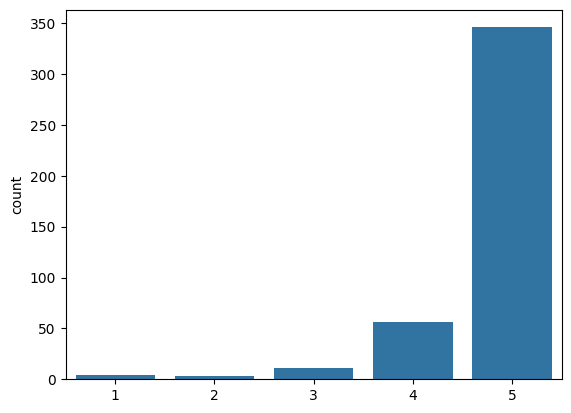

In [10]:
_ = sns.countplot(x=stars_list)

In [11]:
# llM 학습이 잘 되도록 리뷰 시작과 끝 부분을 표시해줌
# 5점인 것과 아닌 것으로 나눔
reviews_high, reviews_low = [], []

for i in review_list:
    if i['stars'] ==5:
        reviews_high.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')
    else:
        reviews_low.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')
print(reviews_high[:3])

['[REVIEW_START]고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.[REVIEW_END]', '[REVIEW_START]커피쿠폰도 받았구 깨끗하고 교회뷰도 이뻤어요!!![REVIEW_END]', '[REVIEW_START]잊을수없는 추억을 남겼어요 너무너무 좋았어요\r\n여자친구 몰래 프로포즈를 준비하게되었는데\r\n프론트 체크인 도와주셨던 직원분께 양해를 구하고\r\n선물을 미리 맡겨주셨고 프로포즈셋팅까지 완벽하게 진행될 수 있도록 정말 많은 도움 주셨어요\r\n바쁘신 와중에도 제가 계획한대로 체크인도 도와주셨고 딜라이브 ott까지 챙겨주시는 섬세함에 감동받았습니다 나중에 기념일때 다시한번 꼭 방문하겠습니다 성함을 기억했어야 하는데 젊은 남직원분\r\n다음번 방문때 감사인사 드리겠습니다\r\n훌륭한 룸컨디션도 칭찬합니다[REVIEW_END]']


In [13]:
review_high_text = '\n'.join(reviews_high)
review_low_text = '\n'.join(reviews_low)
print(review_high_text[:500])

[REVIEW_START]고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.[REVIEW_END]
[REVIEW_START]커피쿠폰도 받았구 깨끗하고 교회뷰도 이뻤어요!!![REVIEW_END]
[REVIEW_START]잊을수없는 추억을 남겼어요 너무너무 좋았어요
여자친구 몰래 프로포즈를 준비하게되었는데
프론트 체크인 도와주셨던 직원분께 양해를 구하고
선물을 미리 맡겨주셨고 프로포즈셋팅까지 완벽하게 진행될 수 있도록 정말 많은 도움 주셨어요
바쁘신 와중에도 제가 계획한대로 체크인도 도와주셨고 딜라이브 ott까지 챙겨주시는 섬세함에 감동받았습니다 나중에 기념일때 다시한번 꼭 방문하겠습니다 성함을 기억했어야 하는데 젊은 남직원분
다음번 방문때 감사인사 드리겠습니다
훌륭한 룸컨디션도 칭찬합니다[REVIEW_END]
[REVIEW_START]조식이 맛있어요!!다양하게 종류도 많구요 캠페


#### 각 전처리 단계를 하나의 함수로 작성
- 야놀자 홈페이지의 후기 요약 기간이 최근 6개월이므로 동일한 조건으로 데이터를 가공

In [17]:
import datetime
from dateutil import parser
# dateutil : 다양한 형식의 날짜와 시간 문자열을 파싱하고 시간대 정보를 처리하는 모듈
# prser : 문자열에서 날짜와 시간 정보를 자동으로 인식하고 추출하는 함수

datetime.datetime.now()

datetime.datetime(2025, 2, 5, 16, 39, 47, 208670)

In [19]:
# 6개월 전 날짜 및 일시 구하기
# timedelta : 두 날짜 또는 시간간의 차이를 나타내는 함수
# weeks, days, hours, minutes, seconds가 있음
datetime.datetime.now() - datetime.timedelta(weeks=24)

datetime.datetime(2024, 8, 21, 16, 39, 47, 442338)

In [162]:
def preprocessing_reviews(path='data/ya_review_sinla.json'):
    # 후기 파일 불러오기
    with open(path, 'r', encoding='utf-8') as f :
        review_list = json.load(f)

    # 5점인 후기, 아닌 후기로 나눌 리스트
    reviews_high, reviews_low = [], []

    # 6개월 이내 데이터 분별을 위한 코드
    current_date = datetime.datetime.now()
    date_boundary = current_date - datetime.timedelta(weeks=24)

    for i in review_list:
        # 년월일 형식이 아닌 경우, 예외처리 필요
        review_date_str =i['date']
        try:
            # parse : 문자열로 적혀진 날짜를 날짜 타입으로 변경
            review_date = parser.parse(review_date_str)

        # 년월일형식이 아닌 값들
        except (ValueError, TypeError) :
            # 어차피 날짜 안 쓰고, 6개월 이내 리뷰가 맞으니까 오늘 날짜로 바꿔버려
            review_date =  current_date

            # 해당 리뷰 날짜가 6개월 전보다 작다면 그냥 넘어감
        if review_date < date_boundary:
            continue

        # 각 REVIEW별 START지점, END지점 표시
        if i['stars'] ==5:
            reviews_high.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')
        else:
            reviews_low.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')

    # 각 REVIEW 하나의 문자열로 변경 
    review_high_text = '\n'.join(reviews_high)
    review_low_text = '\n'.join(reviews_low)

    return review_high_text, review_low_text

47


('[REVIEW_START]조식이 맛있어요!!다양하게 종류도 많구요 캠페인중이여서 할인도 해서 먹었는데 맛있습니다\n직원분들 친절하고 대응도 잘해주세요[REVIEW_END]\n[REVIEW_START]가족들이 간다고 해서 진짜 폭풍 검색해서 알아봐드렸는데 좋아하셔서 좋았습니다 :) 신라스테이는 어딜 가도 좋은것 같아요[REVIEW_END]\n[REVIEW_START]프론트 직원분들이 친절하셔서 좋아요[REVIEW_END]\n[REVIEW_START]아주좋아요오오옹오ㅗ옹[REVIEW_END]\n[REVIEW_START]청결하고 좋습니다 특히 조식이 맛있었어요[REVIEW_END]\n[REVIEW_START]깨끗하고 친잘하고 교통편도 편리해요\n그래서 출장중엔 종종 이용합니다[REVIEW_END]\n[REVIEW_START]서울오면 항상들려요~[REVIEW_END]\n[REVIEW_START]잘 아용하였습니다![REVIEW_END]\n[REVIEW_START]편안하게 잘 쉬다 갑니다.[REVIEW_END]\n[REVIEW_START]조식도 맛있고 주차도 편리하고 좋았습니다^^[REVIEW_END]\n[REVIEW_START]처음 가보았는데 도시에 있어도 소음이 심하지도 않고 객실은 대체적으로 청결하고 좋았습니다[REVIEW_END]\n[REVIEW_START]병원 방문으로 강남에 갔다가 쉴 곳이 필요해 데이유즈로 이용했습니다. 전체적으로 룸 컨디션은 5성급 호텔과 비슷한 수준으로 훌륭했고, 인근에 식당과 카페가 많이 있어 위치도 좋습니다. \n무엇보다 넓은 지하주차장을 가지고 있어, 어딜 가나 주차 스트레스가 심한 강남에서 편히 쉬다 갈 수 있었습니다.[REVIEW_END]\n[REVIEW_START]시설이 깨끗하고 편리하게 이용함[REVIEW_END]\n[REVIEW_START]친절 하고 깨끗해요[REVIEW_END]\n[REVIEW_START]지방에 사는데 아이병원때문에 1박을 해야해서 \n고민하다 신라스테이를 살펴보게되었어요 \n저렴하지만 아이와 조식도 먹

### 리뷰 문장 요약을 위한 Baseline 모델 개발
- base모델(gpt-3.5-turbo)가 야놀자 후기 요약 문장(gpt-4-turbo 모델 사용)에 근접하게 성능을 향상시 보는 것이 우리의 목표!!

In [27]:
reviews, _ = preprocessing_reviews()
reviews[:500]

'[REVIEW_START]고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.[REVIEW_END]\n[REVIEW_START]커피쿠폰도 받았구 깨끗하고 교회뷰도 이뻤어요!!![REVIEW_END]\n[REVIEW_START]잊을수없는 추억을 남겼어요 너무너무 좋았어요\r\n여자친구 몰래 프로포즈를 준비하게되었는데\r\n프론트 체크인 도와주셨던 직원분께 양해를 구하고\r\n선물을 미리 맡겨주셨고 프로포즈셋팅까지 완벽하게 진행될 수 있도록 정말 많은 도움 주셨어요\r\n바쁘신 와중에도 제가 계획한대로 체크인도 도와주셨고 딜라이브 ott까지 챙겨주시는 섬세함에 감동받았습니다 나중에 기념일때 다시한번 꼭 방문하겠습니다 성함을 기억했어야 하는데 젊은 남직원분\r\n다음번 방문때 감사인사 드리겠습니다\r\n훌륭한 룸컨디션도 칭찬합니다[REVIEW_END]\n[REVIEW_START]조식이 맛있어요!!다양하게 종류도 많구요 캠페'

In [29]:
PROMPT_BASELINE = "아래 숙소 리뷰를 5문장 내로 요약해줘:"

In [31]:
# llM호출하여 요약하는 함수
def summarize(reviews, prompt, temperature=0, model='gpt-3.5-turbo'):
    prompt = prompt + '\n\n' + reviews

    completion = client.chat.completions.create(model = model,
                                                messages = [{'role' : 'user',
                                                            'content':prompt}],
                                                temperature = temperature
                                               )
    return completion

#### 모델별 요약 결과

In [34]:
# gpt-3.5
print(summarize(reviews, PROMPT_BASELINE, model='gpt-3.5-turbo').choices[0].message.content)

조식포함으로 결정한 숙소는 시설, 서비스, 청결도 모두 만족스러웠고, 깨끗하고 교회뷰도 이쁘다. 프로포즈를 준비한 손님에게도 섬세한 서비스를 제공해줬다. 위치가 좋고 조식이 맛있어서 가족들이 만족해했다. 프론트 직원들이 친절하고, 깨끗하고 친절한 숙소에서 편안하게 쉬었다.


In [35]:
# gpt-4-turbo
summary_gpt4_turbo = """청결하고 쾌적한 환경을 제공하며, 친절한 직원 서비스가 돋보입니다.
조식은 다양한 메뉴와 맛으로 손님들에게 호평을 받으며, 주차 시설도 편리하게 마련되어 있습니다.
객실은 아늑하고 고급스러운 분위기를 연출하며, 일부 객실에서는 도로 소음이 발생할 수 있습니다.
접근성과 주변 식당, 카페가 다양해 이용객의 편의성이 높습니다. 전반적으로 가성비가 우수하고, 재방문 의사가 있는 곳입니다."""
summary_gpt4_turbo

'청결하고 쾌적한 환경을 제공하며, 친절한 직원 서비스가 돋보입니다.\n조식은 다양한 메뉴와 맛으로 손님들에게 호평을 받으며, 주차 시설도 편리하게 마련되어 있습니다.\n객실은 아늑하고 고급스러운 분위기를 연출하며, 일부 객실에서는 도로 소음이 발생할 수 있습니다.\n접근성과 주변 식당, 카페가 다양해 이용객의 편의성이 높습니다. 전반적으로 가성비가 우수하고, 재방문 의사가 있는 곳입니다.'

### 모델 평가 함수 선언

#### 평가 기준 설정
- MT-bench 논문 기반 Pairwise Comparision 방식 적용
    - LLM 기반 품질 비교 평가
    - gpt-4o를 활용하여 2개 모델(3.5-turbo, 4-turbo)의 요약 결과를 비교하여 평가를 해보자
#### 평가를 위한 스크립트 및 모델 실행 함수 코드 작성
- 기존 MT-bench의 논문의 프롬프트에서 우리의 task에 맞게 일부만 수정해서 활용

In [38]:
# 2개 모델이 요약한 내용을 비교평가하는 함수(리뷰내용, 첫 번쨰 모델 응답, 두 번째 모델 응답)
def pairwise_eval(reviews, answer_a, answer_b):
    eval_prompt = f"""[System]
    Please act as an impartial judge and evaluate the quality of the Korean summaries provided by two
    AI assistants to the set of user reviews on accommodations displayed below. You should choose the assistant that
    follows the user’s instructions and answers the user’s question better. Your evaluation
    should consider factors such as the helpfulness, relevance, accuracy, depth, creativity,
    and level of detail of their responses. Begin your evaluation by comparing the two
    responses and provide a short explanation. Avoid any position biases and ensure that the
    order in which the responses were presented does not influence your decision. Do not allow
    the length of the responses to influence your evaluation. Do not favor certain names of
    the assistants. Be as objective as possible. After providing your explanation, output your
    final verdict by strictly following this format: "[[A]]" if assistant A is better, "[[B]]"
    if assistant B is better, and "[[C]]" for a tie.
    Say Korean

    [User Reviews]
    {reviews}
    [The Start of Assistant A’s Answer]
    {answer_a}
    [The End of Assistant A’s Answer]
    [The Start of Assistant B’s Answer]
    {answer_b}
    [The End of Assistant B’s Answer]"""

    completion = client.chat.completions.create(model = 'gpt-4o',
                                                messages = [{'role':'user',
                                                             'content':eval_prompt}],
                                                temperature = 0
                                               )
    return completion
    

#### base모델(3.5-turbo)과 gpt-4-turbo모델 하나씩 응답에 대해 시범 평가

In [40]:
answer_a = summarize(reviews, PROMPT_BASELINE, model='gpt-3.5-turbo').choices[0].message.content

In [41]:
answer_b = summary_gpt4_turbo

In [42]:
# 평가 함수 실행(pairwise 함수를 호출하여 두 모델의 응답에 대해 gpt-4o모델이 평가함)
print(pairwise_eval(reviews, answer_a, summary_gpt4_turbo).choices[0].message.content)

Assistant A의 답변은 특정 리뷰의 세부 사항을 강조하며, 조식, 시설, 서비스, 청결도, 직원의 친절함 등을 언급하고 있습니다. 특히, 프로포즈를 준비한 손님에 대한 구체적인 사례를 포함하여 개인적인 경험을 강조하고 있습니다. 이는 리뷰의 구체적인 사례를 잘 반영하고 있으며, 사용자에게 특정한 경험을 전달하는 데 효과적입니다.

반면, Assistant B의 답변은 전반적인 요약을 제공하며, 청결, 친절한 서비스, 조식의 다양성, 주차 시설, 객실의 아늑함, 접근성, 가성비 등을 언급하고 있습니다. 이 답변은 전반적인 요약을 통해 다양한 측면을 포괄적으로 다루고 있으며, 일반적인 정보를 제공하는 데 중점을 두고 있습니다.

두 답변 모두 리뷰의 주요 포인트를 잘 반영하고 있지만, Assistant A는 특정한 경험을 강조하여 사용자에게 더 구체적인 정보를 제공하고 있습니다. 반면, Assistant B는 전반적인 요약을 통해 다양한 측면을 포괄적으로 다루고 있습니다. 따라서, 사용자에게 구체적인 경험을 전달하는 데 있어 Assistant A의 답변이 더 효과적이라고 판단됩니다.

[[A]]


### 메인 평가 진행
- 모델 고도화 업시 가장 기본적인 base모델과 gpt-4의 성능을 여러번 비교 평가해보자!
- 실무에서는 다양한 데이터군을 많은 횟수로 평가하지만 지금은 그렇게 하기 힘들기 때문에 temperature를 높여서 다양한 응답을 10개 마들어서 평가를 진행해보자.
- 경험삼 50~100번 정도의 평가를 진행해보면 좋겠지만 시간과 비용의 문제로 10번만 진행

In [44]:
summaries_baseline = [summarize(reviews, PROMPT_BASELINE, temperature = 0.8).choices[0].message.content for _ in range(10)]

In [45]:
summaries_baseline

['조식포함으로 예약한 숙소는 조식이 맛있고 좋은 서비스, 시설, 청결함을 자랑합니다. 다양한 종류의 조식과 커피쿠폰, 깨끗한 시설, 교회 뷰로 만족스러운 숙박이었어요.다음 방문에도 기대됩니다.',
 '조식 포함으로 예약한 숙소는 조식도 맛있고 시설, 서비스, 청결도 모두 훌륭했고, 커피쿠폰도 받아 기쁘게 지내다가 갔어요. 그리고 불편한 점이 없었던 깔끔하고 편안한 숙박을 했습니다. 위치도 좋고, 주차도 편리하며 직원분들도 친절하고 침구도 편안했어요. 이런 호텔이면 항상 이용하고 싶어요.',
 '조식포함으로 결정한 좋은 선택이었고, 조식, 시설, 서비스, 청결 모두 만족스러운 숙소였습니다. 깨끗하고 교회뷰도 이쁘고, 추억을 남기기에 잊을 수 없는 지내이었네요. 다양하고 맛있는 조식, 친절한 직원들, 청결한 객실 등 다양한 요소가 만족스러웠습니다. 또한, 위치도 좋고 가격대비 성능도 좋았음을 언급하며, 다음 방문을 기대하고 있습니다. 위치도 좋고, 청결하고, 친절한 서비스를 제공하는 호텔로 추천합니다.',
 '조식포함으로 결정하여 만족한 숙소. 깨끗하고 시설, 서비스, 청결도 모두 좋았음. 완벽한 프로포즈 서비스를 받고 감동을 남긴 숙소. 깨끗하고 맛있는 조식이 특징. 교회뷰도 이쁘고 커피쿠폰도 제공받음.',
 '1. 조식포함으로 결정한 숙소는 시설, 서비스, 청결도 모두 만족스러웠고, 같이간 이들도 만족스러웠다.\n2. 깨끗하고 교회뷰가 이쁜 숙소였고 커피쿠폰도 받았다.\n3. 프로포즈를 준비했는데 직원들이 많은 도움을 주었고, 다음번 방문 의사가 있다.\n4. 조식이 맛있고 다양하며, 직원들이 친절하였다. \n5. 깨끗하고 친절한 숙소로 출장 시 자주 이용한다.',
 '조식 포함으로 예약한 숙소는 조식이 훌륭하고 시설, 서비스, 청결도 모두 우수하다. 또 다른 리뷰에서는 직원의 도움으로 뜻밖의 프로포즈를 완벽히 준비할 수 있었고, 숙박 시설과 조식이 매우 만족스러웠다고 언급했다. 그 외에도 시설이 깨끗하고 직원이 친절하며 교통편이 좋다는 긍정적인 리뷰가 많이

In [46]:
len(summaries_baseline)

10

In [47]:
# gpt-4 모델의 결과는 같은 것을 사용
summaries_gpt4 = [summary_gpt4_turbo for _ in range(10)]
len(summaries_gpt4)

10

In [48]:
def pairwise_eval_batch(reviews, answer_a, answer_b):
    a_cnt, b_cnt, c_cnt = 0,0,0 # 승리, 패배, 무승부  

    for i in tqdm(range(len(answer_a)):
        completion = pairwise_eval(reviews,answer_a[i],answer_b[i])

        # 평가 결과 텍스트
        result_text = completion.choices[0].message.content

        # A모델이 더 잘했다, B모델이 더 잘했다, C는 무승부
        if '[[A]]' in result_text:
            a_cnt +=1
        elif '[[B]]' in result_text:
            b_cnt +=1
        elif '[[C]]' in result_text:
            c_cnt +=1
        else:
            print('망했다')
            
    return a_cnt, b_cnt, c_cnt
    

In [49]:
wins, loses, ties = pairwise_eval_batch(reviews, summaries_baseline, summaries_gpt4)
print(f"wins : {wins}, loses : {loses}, ties : {ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:53<00:00, 17.38s/it]

wins : 6, loses : 4, ties : 0


### 모델 고도화
#### 1. 프롬프트 엔지니어링
- 페르소나 및 조건 명시
  

In [54]:
prompt = """ 당신은 문장 요약 전문가입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요약하는 것이 당신의 목표입니다.

요약 결과는 다음 조건들을 충족해야 합니다.
1. 모든 문장은 항상 존댓말로 끝나야 합니다.
2. 숙소에 대해 소개하는 톤앤매너로 작성해주세요.
 2-1. 좋은 리뷰 요약 예시
    a) 전반적으로 좋은 숙소였고 방음도 괜찮았다는 평입니다.
    b) 재방문 예정이라는 평들이 존재합니다.

 2-2. 나쁜 리뷰 요약 예시
    a) 좋은 숙소, 방음도 괜찮음.
    b) 재방문 예정.

3. 요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성해주세요.

아래 숙소 리뷰들에 대해 요약해주세요:
"""
# 변경한 프롬프트를 넣어 gpt-3.5 모델로 10번의 요약을 실행
summaries_opti1 = [summarize(reviews, prompt, temperature=0.8).choices[0].message.content for _ in tqdm(range(10))]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.06s/it]


In [55]:
summaries_opti1

['전반적으로 좋은 리뷰들이 많았습니다. \n- 객실 청결과 시설이 좋았고, 조식도 맛있었다고 합니다.\n- 특히, 고객들이 가격 대비 만족하고 친절한 직원들에 대해 언급했습니다.\n- 다만, 몇몇의 아쉬운 점은 주차 요금이 발생하거나 지하철과의 거리가 조금 멀어서 불편감을 느꼈다고 합니다.\n- 하지만 대체적으로 높은 만족도를 느낀다는 평가를 받았습니다. 이용 후 다시 방문할 의사가 있는 리뷰들도 많아요.',
 '고민할 필요 없이 조식포함으로 선택하면 좋은 선택입니다. 전반적으로 시설, 서비스, 청결도 등에서 나무랄 데가 없네요. 커피쿠폰도 받아서 깨끗하고 교회뷰도 이쁘다는 리뷰가 있네요. 또한, 여자친구를 위한 감동적인 프로포즈 이벤트를 개최한 뒤 섬세한 서비스로 고객을 감동시킨 내용도 있습니다. 룸컨디션도 훌륭하다는 평가와 조식이 맛있고 직원들이 친절하다는 좋은 평가도 있습니다. 전반적으로 청결하고 깨끗하며 친절한 서비스로 모든 이용객들의 만족을 이끌어냅니다.',
 '1. 조식포함으로 결정하여 좋은 선택이었고, 같이간 이들도 만족스러워하셨어요.\n2. 깨끗하고 교회 뷰도 이쁘다고 하셨어요.\n3. "잊을수 없는 추억을 남겼어요"라며 여자친구 몰래 프로포즈를 준비했는데, 직원분들이 세심한 배려를 해주셔서 많은 도움을 받았다고 칭찬하셨어요.\n4. 조식이 맛있고, 다양한 종류와 할인 혜택이 있어서 매우 만족하셨다고 소개되었어요.\n5. 병원 방문 후 이용해 좋은 곳이라는 후기도 있었고, 부모님도 편안하게 묵고 가셨다는 소식이 있었습니다.',
 '신라스테이는 항상 좋아하는 곳입니다. 조식도 맛있고 시설도 깨끗하며, 직원들도 친절합니다. 위치가 좋고 편리하며, 주차도 편리한 장점이 있습니다. 전반적으로 만족스럽고, 편안하고 깔끔한 환경에서 휴식을 취할 수 있는 곳입니다. 추억에 남는 좋은 순간을 보내고 갑니다. 또 다시 방문할 의사가 있습니다.',
 '1. 조식포함으로 고민하다가 결정했는데, 좋은 선택이었습니다. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 

In [56]:
wins, loses, ties = pairwise_eval_batch(reviews, summaries_opti1, summaries_gpt4)
print(f"Wins:{wins}, Loses :{loses}, Ties : {ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:00<00:00, 18.03s/it]

Wins:6, Loses :3, Ties : 1


#### 2. 입력 데이터 품질 향상
- 실제 숙소에 대한 정보가 포함되어 있지 않은 단순하고 짧은 리뷰들 필터링 ex) 좋았어요, 굳굳굳 등

In [164]:
# 전처리 함수에 일부 코드 추가
 # 1) 일정 리뷰 길이 미만인 것들을 필터링하며 실제 리뷰와 개수까지 출력
 # 2) 남은 양질의 리뷰 개수 출력시기
def preprocessing_reviews(path='data/ya_review_sinla.json'):
    # 후기 파일 불러오기
    with open(path, 'r', encoding='utf-8') as f :
        review_list = json.load(f)

    # 5점인 후기, 아닌 후기로 나눌 리스트
    reviews_high, reviews_low = [], []

    # 6개월 이내 데이터 분별을 위한 코드
    current_date = datetime.datetime.now()
    date_boundary = current_date - datetime.timedelta(weeks=24)

    # =========== 수정된 코드  ==================
    filtered_cnt = 0 # 필터링된 리뷰 개수    
    # ==========================================

    for i in review_list:
        # 년월일 형식이 아닌 경우, 예외처리 필요
        review_date_str =i['date']
        try:
            # parse : 문자열로 적혀진 날짜를 날짜 타입으로 변경
            review_date = parser.parse(review_date_str)

        # 년월일형식이 아닌 값들
        except (ValueError, TypeError) :
            # 어차피 날짜 안 쓰고, 6개월 이내 리뷰가 맞으니까 오늘 날짜로 바꿔버려
            review_date =  current_date

            # 해당 리뷰 날짜가 6개월 전보다 작다면 그냥 넘어감
        if review_date < date_boundary:
            continue
        
        # =========== 수정된 코드  ==================
        if len(i['review']) < 15: # 글자 수 20개 이하는 스킵
            filtered_cnt +=1
            print(f"필더링 된 리뷰 : {i['review']}")
            continue
        # ==========================================
    
        # 각 REVIEW별 START지점, END지점 표시
        if i['stars'] ==5:
            reviews_high.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')
        else:
            reviews_low.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')

        
    # =========== 수정된 코드  ==================
    reviews_high = reviews_high[:min(len(reviews_high), 50)] # 최대 리뷰 50개까지 사용
    reviews_low = reviews_low[:min(len(reviews_low), 50)]    # gpt3.5는 토큰이 적어서 입,출력이 많으면 응답이 짤릴 가능성이 있음

    print("15자 미만 리뷰 개수 :", filtered_cnt)
    print("필터링 되고 남은 높은 평점 리뷰 개수 : ", len(reviews_high))
    # ==========================================
        

    # 각 REVIEW 하나의 문자열로 변경 
    review_high_text = '\n'.join(reviews_high)
    review_low_text = '\n'.join(reviews_low)

    return review_high_text, review_low_text

필더링 된 리뷰 : 아주좋아요오오옹오ㅗ옹
필더링 된 리뷰 : 잘자고 가요오오 ~~
필더링 된 리뷰 : 서울오면 항상들려요~
필더링 된 리뷰 : 잘 아용하였습니다!
필더링 된 리뷰 : 편하게 놀고 쉬고 왔어요
필더링 된 리뷰 : 편안하게 잘 쉬다 갑니다.
필더링 된 리뷰 : 친절 하고 깨끗해요
필더링 된 리뷰 : 잘 쉬다갑니다
대체로 괜춘
필더링 된 리뷰 : 편하게 쉬고 왔습니다!
필더링 된 리뷰 : 너무 깨끗하고 좋아요
필더링 된 리뷰 : 너무 깨끗하고 좋아요
필더링 된 리뷰 : 잘쉬다가가갑니다아ㅡ
필더링 된 리뷰 : 편히 잘 쉬고 갑니다
필더링 된 리뷰 : 편안하게 잘쉬다가 갑니다
필더링 된 리뷰 : 깨끗하고 편안했어요 좋아요
필더링 된 리뷰 : 잘쉬다가갑니다 규ㅛ굿
15자 미만 리뷰 개수 : 16
필터링 되고 남은 높은 평점 리뷰 개수 :  33


('[REVIEW_START]조식이 맛있어요!!다양하게 종류도 많구요 캠페인중이여서 할인도 해서 먹었는데 맛있습니다\n직원분들 친절하고 대응도 잘해주세요[REVIEW_END]\n[REVIEW_START]가족들이 간다고 해서 진짜 폭풍 검색해서 알아봐드렸는데 좋아하셔서 좋았습니다 :) 신라스테이는 어딜 가도 좋은것 같아요[REVIEW_END]\n[REVIEW_START]프론트 직원분들이 친절하셔서 좋아요[REVIEW_END]\n[REVIEW_START]청결하고 좋습니다 특히 조식이 맛있었어요[REVIEW_END]\n[REVIEW_START]깨끗하고 친잘하고 교통편도 편리해요\n그래서 출장중엔 종종 이용합니다[REVIEW_END]\n[REVIEW_START]조식도 맛있고 주차도 편리하고 좋았습니다^^[REVIEW_END]\n[REVIEW_START]처음 가보았는데 도시에 있어도 소음이 심하지도 않고 객실은 대체적으로 청결하고 좋았습니다[REVIEW_END]\n[REVIEW_START]병원 방문으로 강남에 갔다가 쉴 곳이 필요해 데이유즈로 이용했습니다. 전체적으로 룸 컨디션은 5성급 호텔과 비슷한 수준으로 훌륭했고, 인근에 식당과 카페가 많이 있어 위치도 좋습니다. \n무엇보다 넓은 지하주차장을 가지고 있어, 어딜 가나 주차 스트레스가 심한 강남에서 편히 쉬다 갈 수 있었습니다.[REVIEW_END]\n[REVIEW_START]시설이 깨끗하고 편리하게 이용함[REVIEW_END]\n[REVIEW_START]지방에 사는데 아이병원때문에 1박을 해야해서 \n고민하다 신라스테이를 살펴보게되었어요 \n저렴하지만 아이와 조식도 먹을수 있고 무엇보다 \n깨끗한 숙소를 잡아야해서 안전빵으로 \n신라스테이를 예약후 방문했습니다\n친절하신 직원분덕분에 안내를 잘 받았었고\n쾌적한 온도와 습도로 잘 쉬었습니다\n건물뒤편에 술집이나 식사할만한곳이 꽤 있었어요\n또 올라가게 된다면 재방문의사 있습니다^^[REVIEW_END]\n[REVIEW_START]청결도 좋구요 특히 직원분들이 친절

In [60]:
# 변경된 전처리 함수로 데이터 전처리
reviews, _ = preprocessing_reviews('data/ya_review_sinla.json')

# 두번째 고도화
summaries_opti2 = [summarize(reviews, prompt, temperature = 0.8).choices[0].message.content for _ in range(10)]

필더링 된 리뷰 : 아주좋아요오오옹오ㅗ옹
필더링 된 리뷰 : 잘자고 가요오오 ~~
필더링 된 리뷰 : 서울오면 항상들려요~
필더링 된 리뷰 : 잘 아용하였습니다!
필더링 된 리뷰 : 편하게 놀고 쉬고 왔어요
필더링 된 리뷰 : 편안하게 잘 쉬다 갑니다.
필더링 된 리뷰 : 친절 하고 깨끗해요
필더링 된 리뷰 : 잘 쉬다갑니다
대체로 괜춘
필더링 된 리뷰 : 편하게 쉬고 왔습니다!
필더링 된 리뷰 : 너무 깨끗하고 좋아요
필더링 된 리뷰 : 너무 깨끗하고 좋아요
필더링 된 리뷰 : 잘쉬다가가갑니다아ㅡ
필더링 된 리뷰 : 편히 잘 쉬고 갑니다
필더링 된 리뷰 : 편안하게 잘쉬다가 갑니다
필더링 된 리뷰 : 깨끗하고 편안했어요 좋아요
필더링 된 리뷰 : 잘쉬다가갑니다 규ㅛ굿
필더링 된 리뷰 : 침구가 깔끔해서 좋아요
필더링 된 리뷰 : 으ㅡ어저저둬야아차안
필더링 된 리뷰 : 편안하게 잘쉬다왔습니다.
필더링 된 리뷰 : 좋라요돟러ㅛ도로럿ㅍㅇ덜셮
필더링 된 리뷰 : 항상 자주 애용합니다 ㅎㅎ
필더링 된 리뷰 : 너무 깨끗하고 편해요
필더링 된 리뷰 : 가성비 호텔,,,,,
필더링 된 리뷰 : 좋아용ㅎㅎㅎㅎㅎㅎㅎ
필더링 된 리뷰 : 깨끗하고 친절하고 좋아요
필더링 된 리뷰 : 깨끗하고 친절하고 좋아요
필더링 된 리뷰 : 위치랑 모든게 편리해요
필더링 된 리뷰 : 훌륭해요 너무깨끗해요
필더링 된 리뷰 : 좋아요 . 가격이 착해요
필더링 된 리뷰 : 좋았습니다 자주올것같아여
필더링 된 리뷰 : 항상 이용하고있습니다 ㅎㅎ
필더링 된 리뷰 : 깔끔하고 청결합니다
필더링 된 리뷰 : 조앗ㄹ어여!!굳굳굳
필더링 된 리뷰 : 깔끔하고좋았어요 ㅎㅎ
필더링 된 리뷰 : .,.,....,,
필더링 된 리뷰 : 감사합니다. 감사합니다.
필더링 된 리뷰 : 깨끗합니다~~~~~~~~~
필더링 된 리뷰 : 침대가 조금 작았어요
필더링 된 리뷰 : 상당히 좋았습니다.
필더링 된 리뷰 : 항상 좋은 곳 추천합니다.
필더링 된 리뷰 : 너무친절해요 깨끗해요
필더링 된 리뷰 : 즐겁게 쉴 수 있었습니다

In [62]:
summaries_opti2

['좋은 선택이었던 조식포함 숙소, 시설, 서비스, 청결도 완벽했습니다. 깨끗하고 교회뷰도 이쁘고 프로포즈 도와주셔서 감사한 추억이었습니다. 직원분들의 섬세한 배려와 청결한 객실, 맛있는 조식은 특히 인상적이었어요. 직원분들의 친절한 서비스와 깔끔한 시설이 좋았고, 위치도 편리하여 재방문 의사가 있습니다. 호텔 전체적으로 깨끗하고 아늑한 객실, 맛있는 조식, 친절한 직원분들이 좋았습니다.',
 '1. 조식포함으로 결정한 결정은 좋은 선택이었고, 같이간 이들도 만족스러워했습니다. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었습니다.\n2. 추억을 남기기 위해 프로포즈를 준비한 손님은 프론트 직원분의 친절한 도움으로 완벽한 프로포즈를 성공적으로 진행할 수 있었습니다. 섬세한 서비스에 감동받았고, 다음 방문 시에도 기념일을 함께 보내려고 합니다.\n3. 조식이 맛있고 다양한 종류로 제공되어 할인을 받아 먹었는데 맛있었습니다. 직원분들은 친절하고 대응도 잘해주셨습니다.\n4. 가족들이 만족했다는 신라스테이는 어디를 가도 좋다는 선호도를 보여주었습니다. 프론트 직원분들의 친절함도 좋았습니다.',
 '전반적으로 좋은 선택이었던 숙소로, 조식포함으로 결정한 것이 만족스러웠습니다. 친절한 직원과 깨끗한 시설, 그리고 맛있는 조식이 인상적이었습니다. 또한, 프로포즈를 준비한 손님에 대한 세심한 배려로 잊을 수 없는 추억을 만들어주었습니다. 룸 컨디션도 훌륭하며, 다음 방문을 고려하고 있습니다. 이 외에도 조용하고 깨끗한 숙소로, 가격 대비 성능이 좋다는 평가를 받고 있습니다. 시설이 깔끔하고 편리하며, 조식이 맛있는 등 다양한 이유로 만족스러운 숙박 경험을 제공했습니다.',
 '- 조식포함으로 결정한 것은 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.\n- 너무 좋아서 잊을 수 없는 추억을 남겼습니다. 프론트 체크인 도와주신 직원분께 감사의 말씀을 전하고 신라스테이를 강력 추천합니다.\n- 조식이 맛있고

In [63]:
wins, loses, ties = pairwise_eval_batch(reviews, summaries_opti2, summaries_gpt4)
print(f"Wins:{wins}, Loses :{loses}, Ties : {ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.30s/it]

Wins:10, Loses :0, Ties : 0


- 입력 데이터 중에서 요약에 크게 도움이 되지 않는 데이터들을 줄여주는 것만으로도 큰 성능 향상을 볼수 있음
- 그러나 입력된 데이터의 절대적인 개수가 적기 때문에 현재로서는 좋은 모델이라고 섣부르게 판단할 수 없음(실무에서는 더 많은 케이스와 다양한 데이터로 테스트를 해야 함)

### 3.Few-Show learning
- few-show은 질의-응답 쌍의 예시를 들어줘야 하는데 새로운 숙소의 리뷰와 그 요약을 예시로 넣어주자

In [168]:
# 요약 예시를 위해 글래드 강남 호텔의 리뷰를 불러와서 전처리 진행
reviews_1shot, _ = preprocessing_reviews('data/ya_review_glad.json')

summary_1shot = summarize(reviews_1show, prompt, temperature=0, model='gpt-4-turbo').choices[0].message.content

필더링 된 리뷰 : 침구류가 아주 좋네요
필더링 된 리뷰 : 주변 활용도가 높습니다
필더링 된 리뷰 : 가갹대비 편리하고 좋아요
필더링 된 리뷰 : 편안하게 잘 사용했습니다.
필더링 된 리뷰 : 깔끔하고 뷰가 좋아요~
필더링 된 리뷰 : 깨끗해서 기분좋게이용했어요
필더링 된 리뷰 : 위치좋고 편안합니다!
필더링 된 리뷰 : 괜찮았습니다 감사합니다
필더링 된 리뷰 : 너무 깨끗하고 좋습니다~
필더링 된 리뷰 : 접근성이 좋았습니다
필더링 된 리뷰 : 만족하고 푹 쉬다 갑니다
필더링 된 리뷰 : 올때마다 또 오고싶어요
필더링 된 리뷰 : 시간대 선택이 좋으네요
필더링 된 리뷰 : 시간과 예약이 편리해요
15자 미만 리뷰 개수 : 14
필터링 되고 남은 높은 평점 리뷰 개수 :  31


##### 1show에 설명까지 너무 길면 성능이 오히려 감소한다는 걸 보여줌

In [169]:
prompt_1shot = f""" 당신은 문장 요약 전문가입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요약하는 것이 당신의 목표입니다.

요약 결과는 다음 조건들을 충족해야 합니다.
1. 모든 문장은 항상 존댓말로 끝나야 합니다.
2. 숙소에 대해 소개하는 톤앤매너로 작성해주세요.
 2-1. 좋은 리뷰 요약 예시
    a) 전반적으로 좋은 숙소였고 방음도 괜찮았다는 평입니다.
    b) 재방문 예정이라는 평들이 존재합니다.

 2-2. 나쁜 리뷰 요약 예시
    a) 좋은 숙소, 방음도 괜찮음.
    b) 재방문 예정.

3. 요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성해주세요.


[예시 리뷰들] :
{reviews_1shot}

[예시 요약 결과] :
{summary_1shot}

아래 숙소 리뷰들에 대해 요약해주세요:
"""

summaries_opti3 = [summarize(reviews, prompt_1shot, temperature = 0.8).choices[0].message.content for _ in range(10)]

In [170]:
wins, loses, ties = pairwise_eval_batch(reviews, summaries_opti3, summaries_gpt4)
print(f"Wins:{wins}, Loses :{loses}, Ties : {ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.66s/it]

Wins:3, Loses :7, Ties : 0


##### 1shot을 하는 대신 프롬프트를 줄여주는 게 더 좋을 수 있다는 예시

In [171]:
prompt_1shot_ver2 = f""" 당신은 문장 요약 전문가입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요약하는 것이 당신의 목표입니다.
요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성해주세요.

다음은 참고할 리뷰들과 그에 대한 요약 예시입니다.

[예시 리뷰들] :
{reviews_1shot}

[예시 요약 결과] :
{summary_1shot}

아래 숙소 리뷰들에 대해 요약해주세요:
"""

summaries_opti4 = [summarize(reviews, prompt_1shot_ver2, temperature = 0.8).choices[0].message.content for _ in range(10)]

In [172]:
wins, loses, ties = pairwise_eval_batch(reviews, summaries_opti4, summaries_gpt4)
print(f"Wins:{wins}, Loses :{loses}, Ties : {ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.93s/it]

Wins:7, Loses :3, Ties : 0


In [173]:
# 요약 예시를 위해 in9 호텔의 리뷰를 불러와서 전처리 진행
reviews_2shot, _ = preprocessing_reviews('data/ya_review_in9.json')

summary_2shot = summarize(reviews_2shot, prompt_1shot_ver2, temperature=0, model='gpt-4-turbo').choices[0].message.content

필더링 된 리뷰 : 깨끗하고 청결해서 좋았어요
필더링 된 리뷰 : 주차편하고좋아요~~~
필더링 된 리뷰 : 깨끗하고 조용해요.
필더링 된 리뷰 : 생각보다 방이 좁았어요
필더링 된 리뷰 : 깔끔하고 가성비 좋아요
필더링 된 리뷰 : 침구류가 좋고 깨끗해요
15자 미만 리뷰 개수 : 6
필터링 되고 남은 높은 평점 리뷰 개수 :  20


In [174]:
prompt_2shot = f""" 당신은 문장 요약 전문가입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요약하는 것이 당신의 목표입니다.
요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성해주세요.

다음은 참고할 리뷰들과 그에 대한 요약 예시입니다.

[예시 리뷰들 1] :
{reviews_1shot}

[예시 요약 결과 1] :
{summary_1shot}

[예시 리뷰들 2] :
{reviews_2shot}

[예시 요약 결과 2] :
{summary_2shot}

아래 숙소 리뷰들에 대해 요약해주세요:
"""

summaries_opti5 = [summarize(reviews, prompt_2shot, temperature = 0.8).choices[0].message.content for _ in range(10)]

In [175]:
wins, loses, ties = pairwise_eval_batch(reviews, summaries_opti5, summaries_gpt4)
print(f"Wins:{wins}, Loses :{loses}, Ties : {ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:41<00:00, 10.11s/it]

Wins:8, Loses :2, Ties : 0


## two-show, 평가 횟수 20번, 가장 wins가 높은 결과 코드 캡쳐

In [ ]:
prompt_2shot = f""" 당신은 문장 요약 전문가입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요약하는 것이 당신의 목표입니다.
요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성해주세요.

다음은 참고할 리뷰들과 그에 대한 요약 예시입니다.

[예시 리뷰들 1] :
{reviews_1shot}

[예시 요약 결과 1] :
{summary_1shot}

[예시 리뷰들 2] :
{reviews_2shot}

[예시 요약 결과 2] :
{summary_2shot}

아래 숙소 리뷰들에 대해 요약해주세요:
"""

summaries_opti6 = [summarize(reviews, prompt_2shot, temperature = 0.8).choices[0].message.content for _ in range(20)]
summaries_gpt4_20 = [summary_gpt4_turbo for _ in range(20)]

wins, loses, ties = pairwise_eval_batch(reviews, summaries_opti5, summaries_gpt4_20)
print(f"Wins:{wins}, Loses :{loses}, Ties : {ties}")